## Oversampling

Kod undersamplinga smo smanjili broj valjanih transakcija da odgovara broju prevara. Sada ćemo koristit suportnu tehniku odnosno oversampling. Kod oversamlpinga povećavamo broj prevara tako da odgovara broju valjanih transakcija (dupliciramo transakcije koje su prevare više puta). Primjetimo da oversampling vršimo samo na trening skupu nakon podjele na trening i testni skup. U suprotnom bi možda duplicirani podaci bili i u trening i u testnom skupu, pa bi bilo lakše klasificirati neku transakciju (jer je model treniran na istoj).

In [4]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [5]:
%run preprocessing_ccfd.ipynb

In [6]:
%run functions.ipynb

Tehnike oversamplinga koje koristimo su:
<ul>
    <li>Nasumični oversampling</li>
    <li>SMOTE (Synthetic Minority Oversampling TEhnique</li>
    <li>BorderlineSMOTE</li>
    <li>ADASYN (ADAptive SYNthetic sampling)</li>
</ul>
Opišimo sada ukratko svaku od tih tehnika.
<br>
Kod nasumičnog oversamplinga dupliciramo primjerke (transakcije) malobrojnije klase (samo u skupu za trening) da bismo uravnotežili klase. Ovakvim balansom ne uvodimo nikakve nove informacije (jer smo samo duplicirali već potojeće).<br>
Za razliku od nasumičnog oversamplinga SMOTE-om u skup dodajemo nove informacije jer je SMOTE tehnika kojom na temelju informacija o nekoj klasi 'umjetno' stvaramo nove primjere koji su po značajkama bliski klasi koju želimo duplicitati.<br>
BorderlineSMOTE je posebna ekstenzija SMOTE-a koja 'izbire' one primjerke malobrojnije klase koji su najteži za klasificirati (najvjerojatnije je da će ih model pogrešno klasificirati). BorderlineSMOTE onda vrši oversampling samo na tim 'najtežim' primjerima.<br>
ADASYN je također posebna ekstenzija SMOTE-a koja generira nove primjerke inverzno proporcionalno njihovoj gustoći u manjinskoj klasi. Znači više primjeraka će biti generirano 'bliže' onima koje je teško za klasificirati (slično kao i BorderlineSMOTE), a manje kod onih koje je lakše.<br> 

In [3]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_osample_train, y_osample_train = oversample.fit_resample(X_data_train, y_data_train)
y_osample_non_fraud_num = y_osample_train.value_counts()[0]
y_osample_fraud_num = y_osample_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon oversamplinga: ' + str(y_osample_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon oversamplinga: ' + str(y_osample_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon oversamplinga: ' + str(y_osample_fraud_num + y_osample_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon oversamplinga: 227451
Broj prevarantskih transakcija u trening skupu nakon oversamplinga: 227451
Ukupan broj transakcija u trening skupu nakon oversamplinga: 454902


## Logistička regresija

Prva oversampling tehnika koju koristimo je nasumični oversampling.

In [22]:
log_reg_t_start = time.time()
osample_log_reg = LogisticRegression(solver='liblinear')
osample_log_reg.fit(X_osample_train, y_osample_train)

osample_log_reg_training_score = cross_val_score(osample_log_reg, X_osample_train, y_osample_train, cv=rskf)
log_reg_t_end = time.time()

print('Rezultat treniranja za logističku regresiju nad oversampliranim datasetom: ' 
     + str(round(osample_log_reg_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za logističku regresiju: ' + str(round(log_reg_t_end - log_reg_t_start, 2)) + ' seconds.')

Rezultat treniranja za logističku regresiju nad oversampliranim datasetom: 94.77%
Duljina treninga za logističku regresiju: 110.92 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.25%
	Recall score: 91.84%
	F1 score: 11.700000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


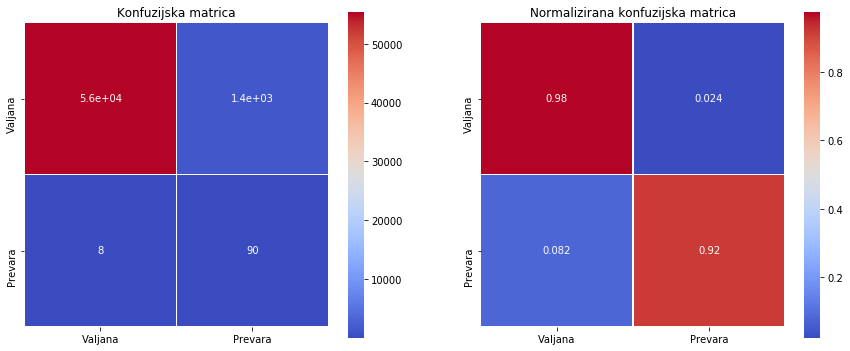

----------------------------------------------------------------------------------------------------


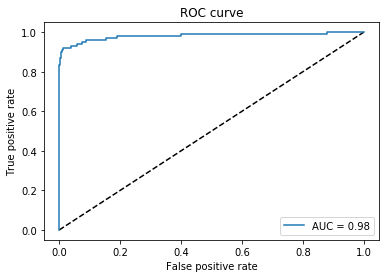

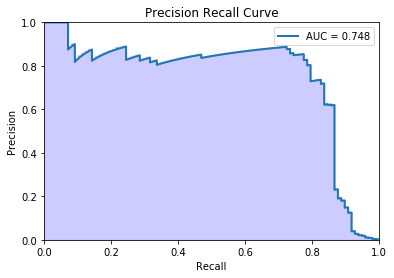

In [24]:
osample_pred_log_reg = osample_log_reg.predict(X_data_test)
osample_score_log_reg = osample_log_reg.decision_function(X_data_test)
print_everything(y_data_test, osample_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, osample_score_log_reg, True)

Za nasummični oversampling sa logističkom regresijom dobili smo poprilično dobre rezultate. Preciznost (6.25%) i f1-mjera (11.7%) su dosta niski, ali je zato osjetljivost vrlo visoka (91.84%). Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao čak 90 prevara (od 98 ukupno). S druge strane isti model je ~1400 valjanih transakcija klasificirao kao prevare. Vidimo i da je površina ispod PR-krivulje nešto viša nego što smo imali korištenjem undersamplinga (ovdje je 0.748). Trening je trajao nešto manje od 2 minute što je vrlo brzo.

In [27]:
#SMOTE

In [68]:
from imblearn.over_sampling import SMOTE

smote_log_reg_t_start = time.time() 
smote_log_reg = LogisticRegression(solver='liblinear')

smote_pipeline = imbalanced_make_pipeline(SMOTE(random_state=42, sampling_strategy='minority'), smote_log_reg)
smote_model = smote_pipeline.fit(X_data_train, y_data_train)
smote_log_reg_training_score = cross_val_score(smote_log_reg, X_data_train, y_data_train, cv=rskf)
smote_log_reg_t_end = time.time()

print('Rezultat treniranja za logističku regresiju nad SMOTE-oversampliranim datasetom: ' 
     + str(round(smote_log_reg_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za logističku regresiju (nad SMOTE): ' + str(round(smote_log_reg_t_end - smote_log_reg_t_start, 2)) + ' seconds.')

Rezultat treniranja za logističku regresiju nad SMOTE-oversampliranim datasetom: 99.92%
Duljina treninga za logističku regresiju (nad SMOTE): 50.57 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.82%
	Recall score: 91.84%
	F1 score: 10.94%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


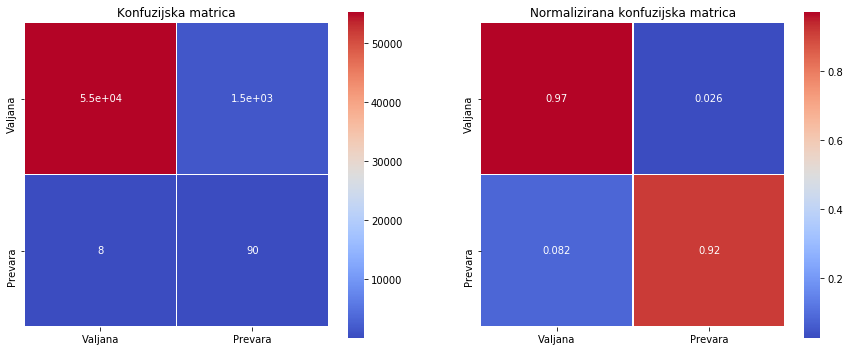

----------------------------------------------------------------------------------------------------


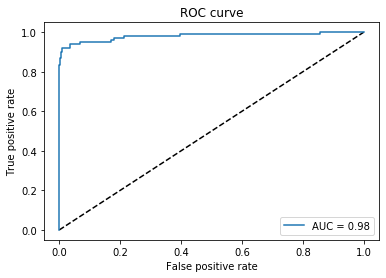

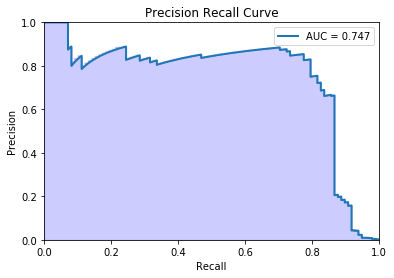

In [73]:
smote_pred_log_reg = smote_model.predict(X_data_test)
smote_score_log_reg = smote_model.decision_function(X_data_test)
print_everything(y_data_test, smote_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, smote_score_log_reg, True)

Koristeći oversampling tehniku SMOTE dobili smo slične rezultate kao i nasumičnim oversamplingom. Preciznost (5.82%) i f1-mjera (10.92%) su nešto niži, dok je osjetljivost potpuno ista (91.84%). Iz matrice konfuzije vidimo da je i ovdje ispravno klasificirano 90 prevara, dok je ipak pogrešno klasificirano ~1500 valjanih transakcija (za nasumični oversampling je bilo oko 1400). Površina ispod PR-krivulje je 0.747 (što se od prošlog modela razlikuje tek na trećoj decimali). Valjalo bi napomenuti i da je u ovom slučaju treniranj bilo dvostruko brže (manje od 1 minute).

In [ ]:
# adasyn

In [70]:
from imblearn.over_sampling import ADASYN

adasyn_log_reg_t_start = time.time() 
adasyn_log_reg = LogisticRegression(solver='liblinear')

adasyn_pipeline = imbalanced_make_pipeline(ADASYN(sampling_strategy='minority'), adasyn_log_reg)
adasyn_model = smote_pipeline.fit(X_data_train, y_data_train)
adasyn_log_reg_training_score = cross_val_score(adasyn_log_reg, X_data_train, y_data_train, cv=rskf)
adasyn_log_reg_t_end = time.time()

print('Rezultat treniranja za logističku regresiju nad ADASYN-oversampliranim datasetom: ' 
     + str(round(adasyn_log_reg_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za logističku regresiju (nad ADASYN): ' + str(round(adasyn_log_reg_t_end - adasyn_log_reg_t_start, 2)) + ' seconds.')

Rezultat treniranja za logističku regresiju nad ADASYN-oversampliranim datasetom: 99.92%
Duljina treninga za logističku regresiju (nad ADASYN): 51.86 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.82%
	Recall score: 91.84%
	F1 score: 10.94%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


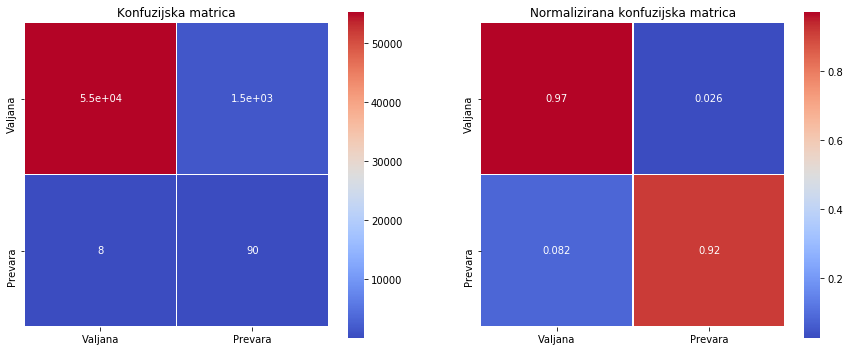

----------------------------------------------------------------------------------------------------


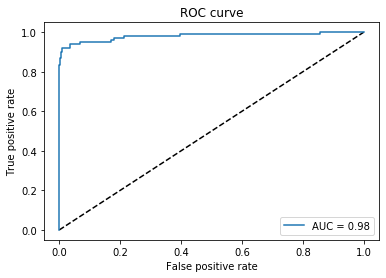

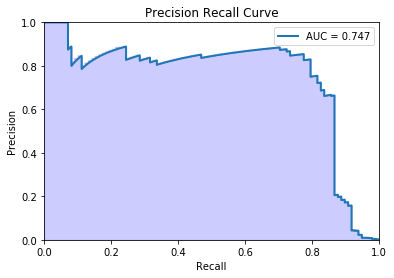

In [72]:
adasyn_pred_log_reg = adasyn_model.predict(X_data_test)
adasyn_score_log_reg = adasyn_model.decision_function(X_data_test)
print_everything(y_data_test, adasyn_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, adasyn_score_log_reg, True)

Sljedeća oversampling tehnika koju koristimo kod logističke regresije je ADASYN. Koristeći tu tehniku dobili smo prakitčno iste rezultate kao i sa SMOTE-om pa ih nećemo previše komentirati (čak i u vremenima za trening).  

In [76]:
from imblearn.over_sampling import BorderlineSMOTE

bs_log_reg_t_start = time.time() 
bs_log_reg = LogisticRegression(solver='liblinear')

bs_pipeline = imbalanced_make_pipeline(BorderlineSMOTE(sampling_strategy='minority'), bs_log_reg)
bs_model = bs_pipeline.fit(X_data_train, y_data_train)
bs_log_reg_training_score = cross_val_score(bs_log_reg, X_data_train, y_data_train, cv=rskf)
bs_log_reg_t_end = time.time()

print('Rezultat treniranja za logističku regresiju nad BorderlineSMOTE-oversampliranim datasetom: ' 
     + str(round(bs_log_reg_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za logističku regresiju (nad BorderlineSMOTE): ' + str(round(bs_log_reg_t_end - bs_log_reg_t_start, 2)) + ' seconds.')

Rezultat treniranja za logističku regresiju nad BorderlineSMOTE-oversampliranim datasetom: 99.92%
Duljina treninga za logističku regresiju (nad BorderlineSMOTE): 61.97 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 11.25%
	Recall score: 82.65%
	F1 score: 19.8%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.83      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.91      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


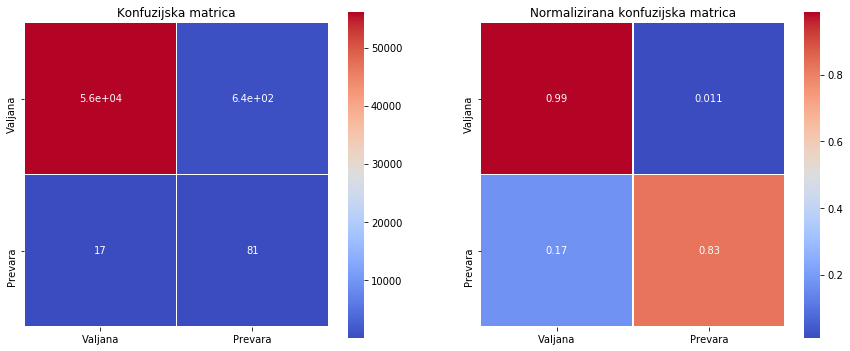

----------------------------------------------------------------------------------------------------


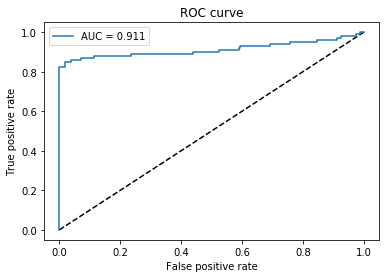

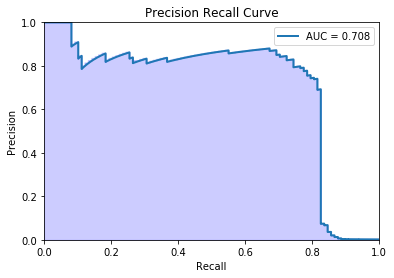

In [77]:
bs_pred_log_reg = bs_model.predict(X_data_test)
bs_score_log_reg = bs_model.decision_function(X_data_test)
print_everything(y_data_test, bs_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, bs_score_log_reg, True)

Koristeći oversampling tehniku BorderlineSMOTE, dobili smo prilično drugačije rezultate. Ovaj model ima nešto višu preciznost (11.25%) te f1-mjeru (19.8%), no zato je i osjetljivost dosta niža (82.65%). Iz konfuzijske matrice vidimo da je ovaj model ispravno klasificirao samo 81 prevara (9 manje od prošli), no zato je i pogrešno klasificirao manje valjanih transakcija (~640, a bilo je ~1500). Površina ispod PR-krivulje je također nešto manja (0.708). Vrijeme potrebno za treniranje je opet bilo oko 1 minute.  

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

under_sampler = RandomUnderSampler(sampling_strategy='majority')
smote_sampler = SMOTE(sampling_strategy='minority')
smote_under_log_reg = LogisticRegression(solver='liblinear')

time_sm_und_start = time.time()
smote_under_pipeline = imbalanced_make_pipeline(smote_sampler, under_sampler, smote_under_log_reg)
smote_under_model = smote_under_pipeline.fit(X_data_train, y_data_train)
smote_under_pred = smote_under_model.predict(X_data_test)

training_smote_under_score = cross_val_score(smote_under_pipeline, X_data_train, y_data_train, cv=rskf)
time_sm_und_end = time.time()
print('Logistička regresija (sa kombinacijom SMOTE-a i nasumičnog undersamplinga)')

print('Rezultat treniranja za logističku regresiju nad kombinacijom SMOTE-a i nasumičnog undersamplinga: ' 
     + str(round(training_smote_under_score.mean(), 4) * 100) + '%')
print('Vrijeme potrebno za trening logističke regresije (sa kombinacijom SMOTE-a i undersamplinga): ' + 
      str(time_sm_und_end-time_sm_und_start))

Logistička regresija (sa kombinacijom SMOTE-a i nasumičnog undersamplinga)
Rezultat treniranja za logističku regresiju nad kombinacijom SMOTE-a i nasumičnog undersamplinga: 97.45%
Vrijeme potrebno za trening logističke regresije (sa kombinacijom SMOTE-a i undersamplinga): 130.41597628593445


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.75%
	Recall score: 91.84%
	F1 score: 10.82%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


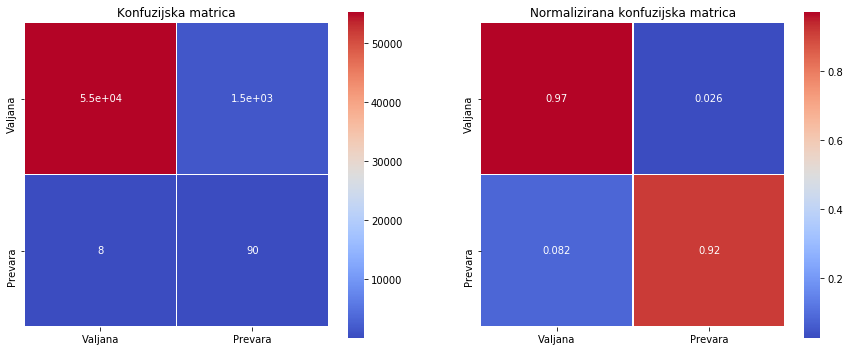

----------------------------------------------------------------------------------------------------


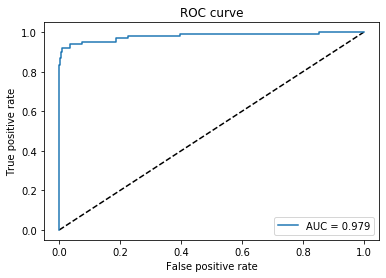

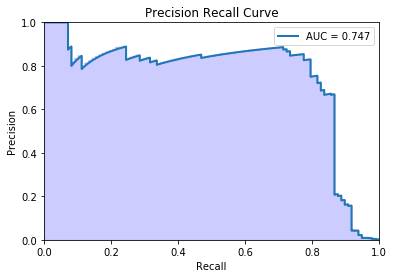

In [11]:
smote_under_pred_log_reg = smote_under_model.predict(X_data_test)
smote_under_score_log_reg = smote_under_model.decision_function(X_data_test)
print_everything(y_data_test, smote_under_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, smote_under_score_log_reg, True)

Kombinacijom SMOTE-a i nasumičnog undersamplinga dobili smo iste rezultate kao i samim SMOTE-om.

## Slučajne šume

In [82]:
rf_t_start = time.time()
osample_rf = RandomForestClassifier()
osample_rf.fit(X_osample_train, y_osample_train)

osample_rf_training_score = cross_val_score(osample_rf, X_osample_train, y_osample_train, cv=rskf)
rf_t_end = time.time()

print('Rezultat treniranja za slučajne šume nad oversampliranim datasetom: ' 
     + str(round(osample_rf_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za slučajne šume: ' + str(round(rf_t_end - rf_t_start, 2)) + ' seconds.')

Rezultat treniranja za slučajne šume nad oversampliranim datasetom: 100.0%
Duljina treninga za slučajne šume: 13364.16 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 98.72999999999999%
	Recall score: 79.59%
	F1 score: 88.14%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


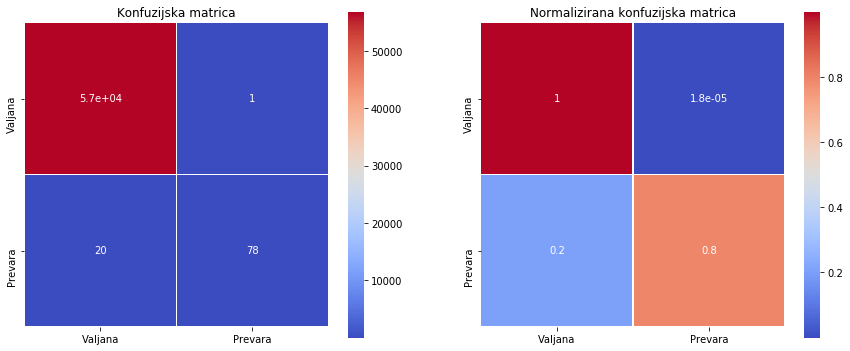

----------------------------------------------------------------------------------------------------


In [83]:
osample_pred_rf = osample_rf.predict(X_data_test)
print_everything(y_data_test, osample_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Prvo što bih spomenuo je da treniranje kod slučajnih šuma traje puno duže (za nasumični oversampling ~3h 40min). Rezultati su vrlo slični onima koje smo dobili i bez oversamplinga. Tako je preciznost vrlo visoka (98.73%), f1-mjera (88.14%) također, dok je osjetljivost nešto niža (79.59%).  Iz matrice konfuzije vidimo da je pogrešno klasificirana samo 1 valjana transakcija, no zato je pogrešno klasificirano čak i 20 prevara.

In [85]:

smote_rf_t_start = time.time() 
smote_rf = RandomForestClassifier()

rf_smote_pipeline = imbalanced_make_pipeline(SMOTE(random_state=42, sampling_strategy='minority'), smote_rf)
rf_smote_model = rf_smote_pipeline.fit(X_data_train, y_data_train)
smote_rf_training_score = cross_val_score(smote_rf, X_data_train, y_data_train, cv=rskf)
smote_rf_t_end = time.time()

print('Rezultat treniranja za slučajne šume nad SMOTE-oversampliranim datasetom: ' 
     + str(round(smote_rf_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za slučajne šume (nad SMOTE): ' + str(round(smote_rf_t_end - smote_rf_t_start, 2)) + ' seconds.')

Rezultat treniranja za slučajne šume nad SMOTE-oversampliranim datasetom: 99.95%
Duljina treninga za slučajne šume (nad SMOTE): 5938.02 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 90.22%
	Recall score: 84.69%
	F1 score: 87.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


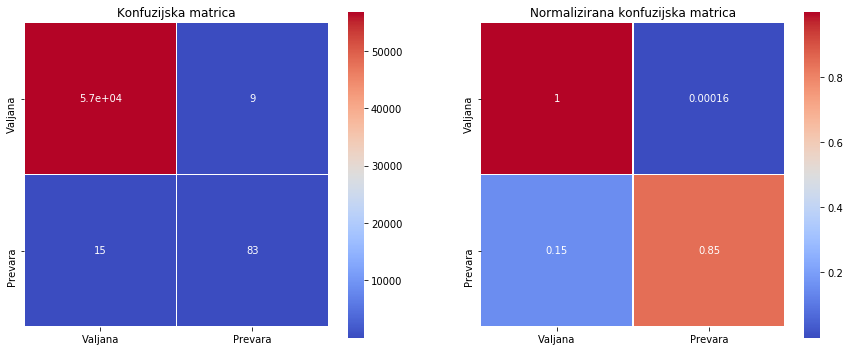

----------------------------------------------------------------------------------------------------


In [86]:
smote_pred_rf = rf_smote_model.predict(X_data_test)
print_everything(y_data_test, smote_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem SMOTE-a sa slučajnim šumama je dalo nešto bolje rezultate. Preciznost (90.22%) i f1-mjera (87.37%) su i dalje vrlo visoke dok je sada i osjetljivost također prilično visoka (84.69%). Iz matrice konfuzije vidimo da je pogrešno klasificirano samo 9 valjanih transakcija (8 više nego nasumičnim oversamplingom), ali sad je i broj pogrešno klasificiranih prevara za 5 manji (nasumičnim oversamplingom je bilo 78, sad je 83). Vrijeme potrebno za trening je opet bilo prilično dugo (oko 1h 40min).

In [6]:

bs_rf_t_start = time.time() 
bs_rf = RandomForestClassifier()

rf_bs_pipeline = imbalanced_make_pipeline(BorderlineSMOTE(random_state=42, sampling_strategy='minority'), bs_rf)
rf_bs_model = rf_bs_pipeline.fit(X_data_train, y_data_train)
bs_rf_training_score = cross_val_score(bs_rf, X_data_train, y_data_train, cv=rskf)
bs_rf_t_end = time.time()

print('Rezultat treniranja za slučajne šume nad BorderlineSMOTE-oversampliranim datasetom: ' 
     + str(round(bs_rf_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za slučajne šume (nad BorderlineSMOTE): ' + str(round(bs_rf_t_end - bs_rf_t_start, 2)) + ' seconds.')

Rezultat treniranja za slučajne šume nad BorderlineSMOTE-oversampliranim datasetom: 99.95%
Duljina treninga za slučajne šume (nad BorderlineSMOTE): 8190.52 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 91.86%
	Recall score: 80.61%
	F1 score: 85.87%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


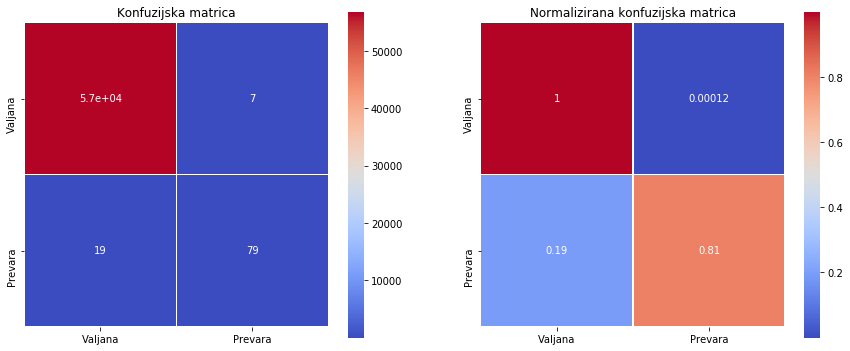

----------------------------------------------------------------------------------------------------


In [7]:
bs_pred_rf = rf_bs_model.predict(X_data_test)
print_everything(y_data_test, bs_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći BorderlineSMOTE sa slučajnim šumama dobili smo značajno bolje rezultate nego sa logističkom regresijom. Sve tri osnovne mjere su u ovom slučaju preko 80%. Preciznost je 91.86%, osjetljivost 80.61%, a f1-mjera 85.87%, odnosno i preciznost i f1-mjera su drastično veće nego kod logističke regresije dok se osjetljivost razlikuje za samo par posto. Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao 79 prevara, te je pogrešno klasificirao 7 valjanih transakcija. Unatoč tome, ovaj model je nešto lošiji od prethodnog (koji koristi klasični SMOTE). 

In [8]:

adasyn_rf_t_start = time.time() 
adasyn_rf = RandomForestClassifier()

rf_adasyn_pipeline = imbalanced_make_pipeline(ADASYN(random_state=42, sampling_strategy='minority'), adasyn_rf)
rf_adasyn_model = rf_adasyn_pipeline.fit(X_data_train, y_data_train)
adasyn_rf_training_score = cross_val_score(adasyn_rf, X_data_train, y_data_train, cv=rskf)
adasyn_rf_t_end = time.time()

print('Rezultat treniranja za slučajne šume nad ADASYN-oversampliranim datasetom: ' 
     + str(round(adasyn_rf_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za slučajne šume (nad ADASYN): ' + str(round(adasyn_rf_t_end - adasyn_rf_t_start, 2)) + ' seconds.')

Rezultat treniranja za slučajne šume nad ADASYN-oversampliranim datasetom: 99.95%
Duljina treninga za slučajne šume (nad ADASYN): 8859.55 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 88.03999999999999%
	Recall score: 82.65%
	F1 score: 85.26%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


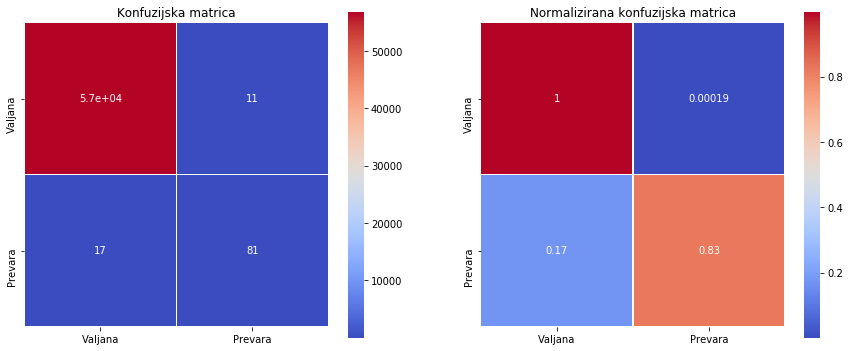

----------------------------------------------------------------------------------------------------


In [9]:
adasyn_pred_rf = rf_adasyn_model.predict(X_data_test)
print_everything(y_data_test, adasyn_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći ADASYN dobili smo nešto bolje rezultate nego BorderlineSMOTE-om (zbog boljeg prepoznavanja prevara). I u ovom slučaju su sve 3 mjere preko 80%. Tako je preciznost 88.04%, osjetljivost 82.65%, a f1-mjera 85.26%. Iz matrice konfuzije vidimo da je model ispravno klasificirao 81 prevaru (2 više nego model koji koristi BorderlineSMOTE), ali i 11 pogrešno klasificiranih valjanih transakcija (4 više nego BorderlineSMOTE).

## XGB (eXtreme Gradient Boosting)

Od boosting algoritama ćemo koristiti XGB (jer je brz i pokazao je dosta dobre rezultate na undersamplingu).

In [12]:
xgb_t_start = time.time()
osample_xgb = XGBClassifier()
osample_xgb.fit(X_osample_train, y_osample_train)

osample_xgb_training_score = cross_val_score(osample_xgb, X_osample_train, y_osample_train, cv=rskf)
xgb_t_end = time.time()

print('Rezultat treniranja za XGB nad oversampliranim datasetom: ' 
     + str(round(osample_xgb_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za XGB: ' + str(round(xgb_t_end - xgb_t_start, 2)) + ' seconds.')

Rezultat treniranja za XGB nad oversampliranim datasetom: 99.67%
Duljina treninga za XGB: 9794.72 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 23.98%
	Recall score: 89.8%
	F1 score: 37.85%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.90      0.38        98

    accuracy                           0.99     56962
   macro avg       0.62      0.95      0.69     56962
weighted avg       1.00      0.99      1.00     56962


----------------------------------------------------------------------------------------------------


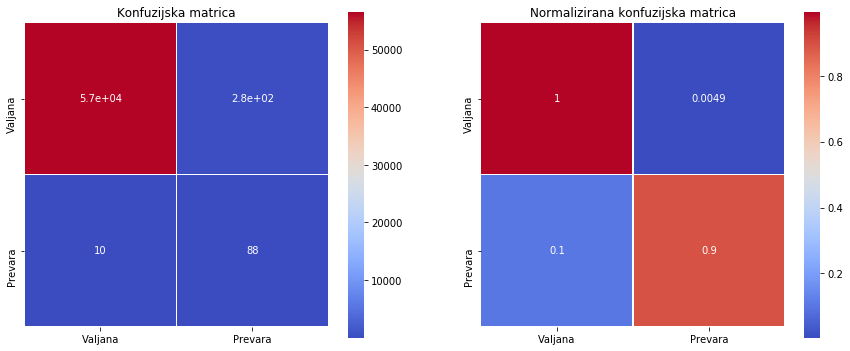

----------------------------------------------------------------------------------------------------


In [13]:
osample_pred_xgb = osample_xgb.predict(X_data_test)
print_everything(y_data_test, osample_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Slučajnim oversamlpingom dobili smo dosta dobre rezultate koristeći XGB. Vidimo da je osjetljivost jako visoka (89.8%), dok su i preciznost (23.98%) te f1-mjera (37.85%). Iz matrice konfuzije vidimo da je čak 88 prevara ispravno klasificirano, dok je i pogrešno klasificiranih valjanih transakcija također dosta malo (oko 280). Vrijeme treniranja je kao i za sve ostale algoritma koji koriste oversampling prilično visoko (oko 2h 40min).

In [15]:

smote_xgb_t_start = time.time() 
smote_xgb = XGBClassifier()

xgb_smote_pipeline = imbalanced_make_pipeline(SMOTE(random_state=42, sampling_strategy='minority'), smote_xgb)
xgb_smote_model = xgb_smote_pipeline.fit(X_data_train, y_data_train)
smote_xgb_training_score = cross_val_score(smote_xgb, X_data_train, y_data_train, cv=rskf)
smote_xgb_t_end = time.time()

print('Rezultat treniranja za XGB nad SMOTE-oversampliranim datasetom: ' 
     + str(round(smote_xgb_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za XGB (nad SMOTE): ' + str(round(smote_xgb_t_end - smote_xgb_t_start, 2)) + ' seconds.')

Rezultat treniranja za XGB nad SMOTE-oversampliranim datasetom: 99.95%
Duljina treninga za XGB (nad SMOTE): 978.02 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 13.33%
	Recall score: 89.8%
	F1 score: 23.22%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


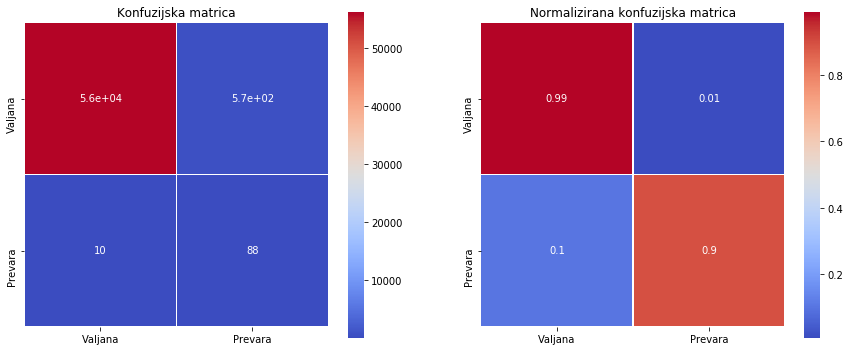

----------------------------------------------------------------------------------------------------


In [16]:
smote_pred_xgb = xgb_smote_model.predict(X_data_test)
print_everything(y_data_test, smote_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći SMOTE smo dobili nešto slabije rezultate nego nasumičnim oversamplingom. Osjetljivost (89.8%) je ista kao kod nasumičnog oversamplinga, ali su zato i preciznost (13.33%) i f1-mjera (23.22%) nešto manje. Iz matrice konfuzije vidimo da je ta razlika u pogrešno klasificiranim valjanim transakcijama (ovdje je ~570, a bilo je ~280). I ovaj model kao i prošli ispravno klasificira 88 prevara. Velika prednost ovog modela je što je za trening bilo potrebno oko 16 min (puno manje od dva i pol sata). 

In [18]:

bs_xgb_t_start = time.time() 
bs_xgb = XGBClassifier()

xgb_bs_pipeline = imbalanced_make_pipeline(BorderlineSMOTE(random_state=42, sampling_strategy='minority'), bs_xgb)
xgb_bs_model = xgb_bs_pipeline.fit(X_data_train, y_data_train)
bs_xgb_training_score = cross_val_score(bs_xgb, X_data_train, y_data_train, cv=rskf)
bs_xgb_t_end = time.time()

print('Rezultat treniranja za XGB nad BorderlineSMOTE-oversampliranim datasetom: ' 
     + str(round(bs_xgb_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za XGB (nad BoorderlineSMOTE): ' + str(round(bs_xgb_t_end - bs_xgb_t_start, 2)) + ' seconds.')

Rezultat treniranja za XGB nad BorderlineSMOTE-oversampliranim datasetom: 99.95%
Duljina treninga za XGB (nad BoorderlineSMOTE): 987.72 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 35.8%
	Recall score: 88.78%
	F1 score: 51.03%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.36      0.89      0.51        98

    accuracy                           1.00     56962
   macro avg       0.68      0.94      0.75     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


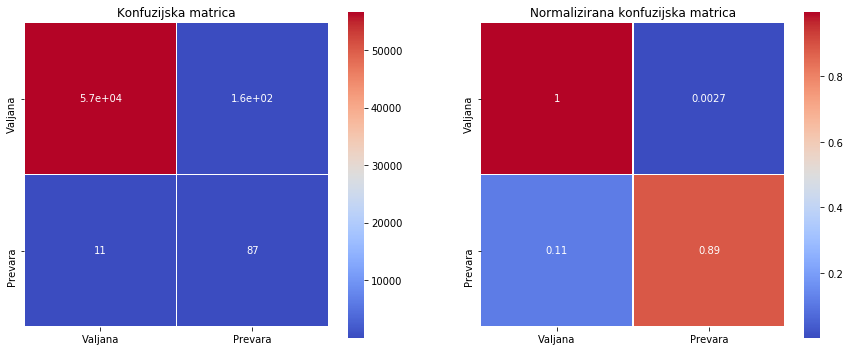

----------------------------------------------------------------------------------------------------


In [19]:
bs_pred_xgb = xgb_bs_model.predict(X_data_test)
print_everything(y_data_test, bs_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći BorderlineSMOTE dobili smo također jako dobre rezultate. Vidimo da su i preciznost (35.8%) i f1-mjera (51.03%) dosta viši nego kod prethodnih modela (koji su za klasifikator koristili XGB), dok je osjetljivost (88.78%) malo manja (bila je 89.8%). Iz matrice konfuzije vidimo da je ispravno klasificirano 87 prevara, dok je pogrešno klasificirano svega ~160 valjanih transakcija.

In [20]:

adasyn_xgb_t_start = time.time() 
adasyn_xgb = XGBClassifier()

xgb_adasyn_pipeline = imbalanced_make_pipeline(ADASYN(random_state=42, sampling_strategy='minority'), adasyn_xgb)
xgb_adasyn_model = xgb_adasyn_pipeline.fit(X_data_train, y_data_train)
adasyn_xgb_training_score = cross_val_score(adasyn_xgb, X_data_train, y_data_train, cv=rskf)
adasyn_xgb_t_end = time.time()

print('Rezultat treniranja za XGB nad ADASYN-oversampliranim datasetom: ' 
     + str(round(adasyn_xgb_training_score.mean(), 4) * 100) + '%')
print('Duljina treninga za XGB (nad ADASYN): ' + str(round(adasyn_xgb_t_end - adasyn_xgb_t_start, 2)) + ' seconds.')

Rezultat treniranja za XGB nad ADASYN-oversampliranim datasetom: 99.95%
Duljina treninga za XGB (nad ADASYN): 968.26 seconds.


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.29%
	Recall score: 91.84%
	F1 score: 8.200000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


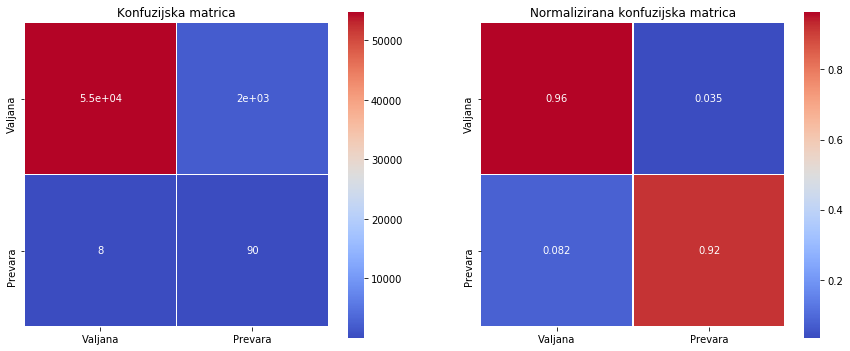

----------------------------------------------------------------------------------------------------


In [21]:
adasyn_pred_xgb = xgb_adasyn_model.predict(X_data_test)
print_everything(y_data_test, adasyn_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Za ADASYN smo dobili nešto drukčije rezultate nego za prethodne 2 metode. Sada su i preciznost (4.29%) i f1-mjera (8.2%) dosta niže, dok je osjetljivost (91.84%) nešto viša. Iz matrice konfuzije vidimo da je ispravno klasificirano čak 90 prevara, ali je i pogrešno klasificirano oko 2000 valjanih transakcija.